<a target="_blank" href="https://colab.research.google.com/github/CLAIR-LAB-TECHNION/ICAPS-24/blob/main/notebooks/ICAPS-SummerSchool-Lab3.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Integrating Task and Motion Planning (cont.)

In the previous tutorial, we demonstrated the difficulties of bridging between the abstract world of task planning and the continuous world of motion planning. Our main goal was to be able to run a plan of PDDL actions and to execute them with a robot. We called this "Task **_THEN_** Motion Planning" and showed that, even in a simulated environment, there are many issues to consider and overcome.

So are we done yet? Not a chance! The word "then" is emphasized because because we are only performing our integration in a single direction (task planning --> motion planning). However, the truly interesting issues arise when attempting to integrate in both directions.

In [ ]:
!pip install "aidm[pddl] @ git+https://github.com/CLAIR-LAB-TECHNION/aidm"
!pip install "git+https://github.com/CLAIR-LAB-TECHNION/ICAPS-24"

  Cloning https://github.com/CLAIR-LAB-TECHNION/aidm to /tmp/pip-install-sj_8n2uy/aidm_85e8d3c332664340b2cfeea9b957d155
  Running command git clone --filter=blob:none --quiet https://github.com/CLAIR-LAB-TECHNION/aidm /tmp/pip-install-sj_8n2uy/aidm_85e8d3c332664340b2cfeea9b957d155
  Resolved https://github.com/CLAIR-LAB-TECHNION/aidm to commit 695eb03f4f0c602133dc72081d2bdad4709a74d6
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/CLAIR-LAB-TECHNION/pddlgymnasium to /tmp/pip-install-sj_8n2uy/pddlgymnasium_71a94ac32da242c4862f3b29b862cf86
  Running command git clone --filter=blob:none --quiet https://github.com/CLAIR-LAB-TECHNION/pddlgymnasium /tmp/pip-install-sj_8n2uy/pddlgymnasium_71a94ac32da242c4862f3b29b862cf86
  Resolved https://github.com/CLAIR-LAB-TECHNION/pddlgymnasium to commit 285a6873d8772a0e9aa473a136994ad07f739109
  P

In [ ]:
%env MUJOCO_GL=egl

env: MUJOCO_GL=egl


In [ ]:
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy

## Task **_AND_** Motion Planning

Hitherto, we expected the motion plan to simply work. We found a single high-level plan and let the skill executer take it from there. Task _then_ motion planning means we trust the motion planner to execute the plan to perfection. But is this a realistic expectation? Of course not! We saw several examples where the motion planner fails. We also implemented **dynamic replanning** which would replan every time an unexpected state was reached. But dynamic replanning is just multiple iterations of task _then_ motion planning. To proudly call our pipeline "task **_AND_** motion planning, we must face the true TAMP demons, and there are many.

So what have we not considerred yet? So far we've addressed the limitations of the motion planner in understanding the task planner. to complete integration, we must make the task planner understand the motion planner.

## The Task Planner Does Not Understand Physical Motion

The task planner does not take into consideration anything outside of the PDDL abstraction. We will show two interesting cases where this can interfere in completing the task.

### Constrained by Geometry

The task planner is unaware of the geometry in the environment. This can come into play in multiple ways. For example:
1. What if there is no more room on the table to add a new block? Our PDDL representation assumed there is enough room for as many blocks as we want on each table. It does not consider that the table has a size limit.
2. What if the only place left to put down a block is too far for the robot to reach? The task planner does not know what is the robot's workspace.
3. what if ther _is_ enough room on the table but the blocks are not arranged to allow this?

Below is a depiction of (3). As we can see, blocks 1-9 are on table 1, and we need to move block 10 from table 2 to table 1. However, the blocks are arranged in such a way that we cannot sample a free spot on the table that won't lead to block collision. A possible solution is to move block 5 up a little to make room for block 10.

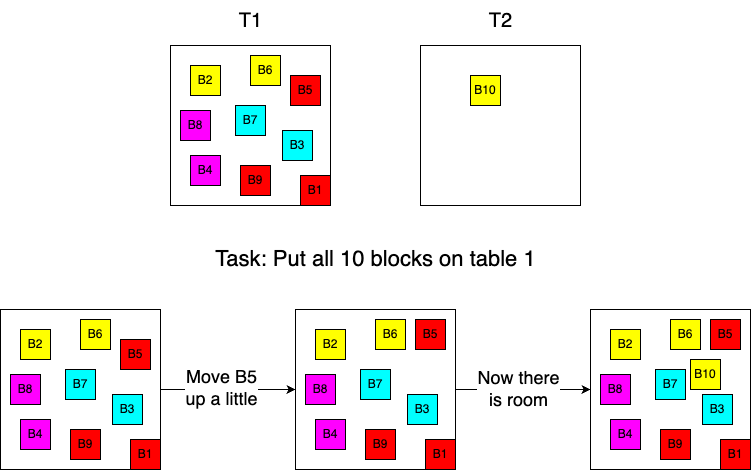

#### Exercise: What other solutions can you think of?

#### Exercise: What if there is no way to rearrange the blocks to make room?

### The Cost of Moving

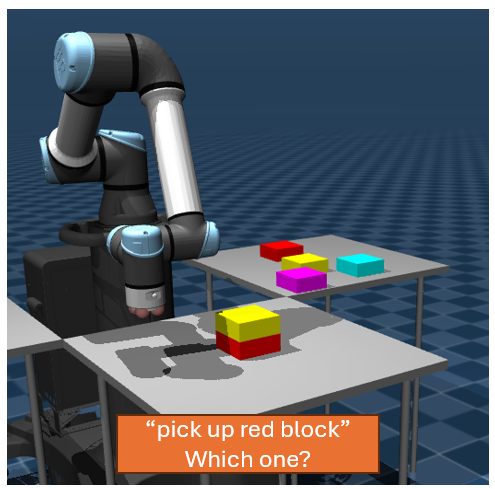

Recall the extended problem in [tutorial 1](https://colab.research.google.com/github/CLAIR-LAB-TECHNION/ICAPS-24/blob/main/notebooks/ICAPS_SummerSchool_Lab1.ipynb). In this problem, a goal is defined using the blocks' colors instead of direct ID. In this case, the agent must make a choice of which of the blocks of the desired color should be acted upon.

- example: need to move a yellow block to some table. gripper is close to 1 that is under a red block and there is a free one in another table. should we unstack or move to the next one?
  - again... is the abstraction not sufficient?
    - e.g. introduce robot location and action cost

## Other Considerations That We Will Not Get Into

- Partial Observability - how can we build a state estimator if we have uncertainty?
- Multi-agent - how do we choose high-level actions with multiple robots to avoid colliding?
- Integrating navigation - what if we need to move somewhere before we can perform the high-level action?
- Lookahead - can we use the task planner to look ahead in the high-level steps to better position the agent to perform these tasks?
- And many more...

### Discussion



- Are we done now? probably never...

### The harsh reality of semantics

- semantics are not machine interpretable
  - our implementation required lots of human intervention
    - we had to write quite a bit of domain-specific code
- semantics are subjective
  - there is no one true mapping between abstract world abstraction and the real world.
    - e.g., is a block on the table if it is touching the table with one edge and leaning on another block?
      - for stacking, probably not
      - for arrangement, possibly

### SOTA TAMP

- So far we implemented a naïve version of TAMP.
- what is SOTA?
  - learning with TAMP
  - TAMP with RL instead of motion control
  - pddlstream
  - ...
- demo [pddlstream](https://github.com/caelan/pddlstream)